(f_rs_io)=

# Opening Remote Sensed Images

---------------
```{admonition} Learning Objectives
  - How to open multiple common remotely sensed image types
  - Handle RGB, BGR, LandSat, PlanetScope images and other sensor types
  - Mosaic multiple images
  - Create a time series stack
```
```{admonition} Review
* [Data Structures](c_features)
* [Raster Data ](c_rasters)
```
--------------


GeoWombat's file opening is meant to mimic Xarray and Rasterio. That is, rasters are typically opened with a context manager using the function `geowombat.open`. GeoWombat uses `xarray.open_rasterio` to load data into an `xarray.DataArray`. In GeoWombat, the data are always chunked, meaning the data are always loaded as Dask arrays. As with `xarray.open_rasterio`, the opened DataArrays always have at least 1 band.

## Opening a single image

Opening an image with default settings looks similar to `xarray.open_rasterio` and `rasterio.open`. `geowombat.open` expects a file name (`str` or `pathlib.Path`).

In [1]:
import geowombat as gw
from geowombat.data import l8_224078_20200518
import matplotlib.pyplot as plt

with gw.open(l8_224078_20200518) as src:
    print(src)

<xarray.DataArray (band: 3, y: 1860, x: 2041)>
dask.array<open_rasterio-2100a9b5874553d9994fcb24fe99bf2d<this-array>, shape=(3, 1860, 2041), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
Attributes:
    transform:          (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                +init=epsg:32621
    res:                (30.0, 30.0)
    is_tiled:           1
    nodatavals:         (nan, nan, nan)
    scales:             (1.0, 1.0, 1.0)
    offsets:            (0.0, 0.0, 0.0)
    AREA_OR_POINT:      Area
    filename:           /home/mmann1123/anaconda3/envs/pygisbookgw/lib/python...
    resampling:         nearest
    data_are_separate:  0
    data_are_stacked:   0


In the example above, `src` is an `xarray.DataArray`. Thus, printing the object will display the underlying Dask array dimensions and chunks, the DataArray named coordinates, and the DataArray attributes.

It automatically converts the coordinates stored in `x` and `y`, and the different bands are stored in `band`. To select a single band we can simply select it with `src.sel(band=1)`.  

Let's plot out what we have while removing missing values, stored at `0`, and switch the band order around to be RGB.

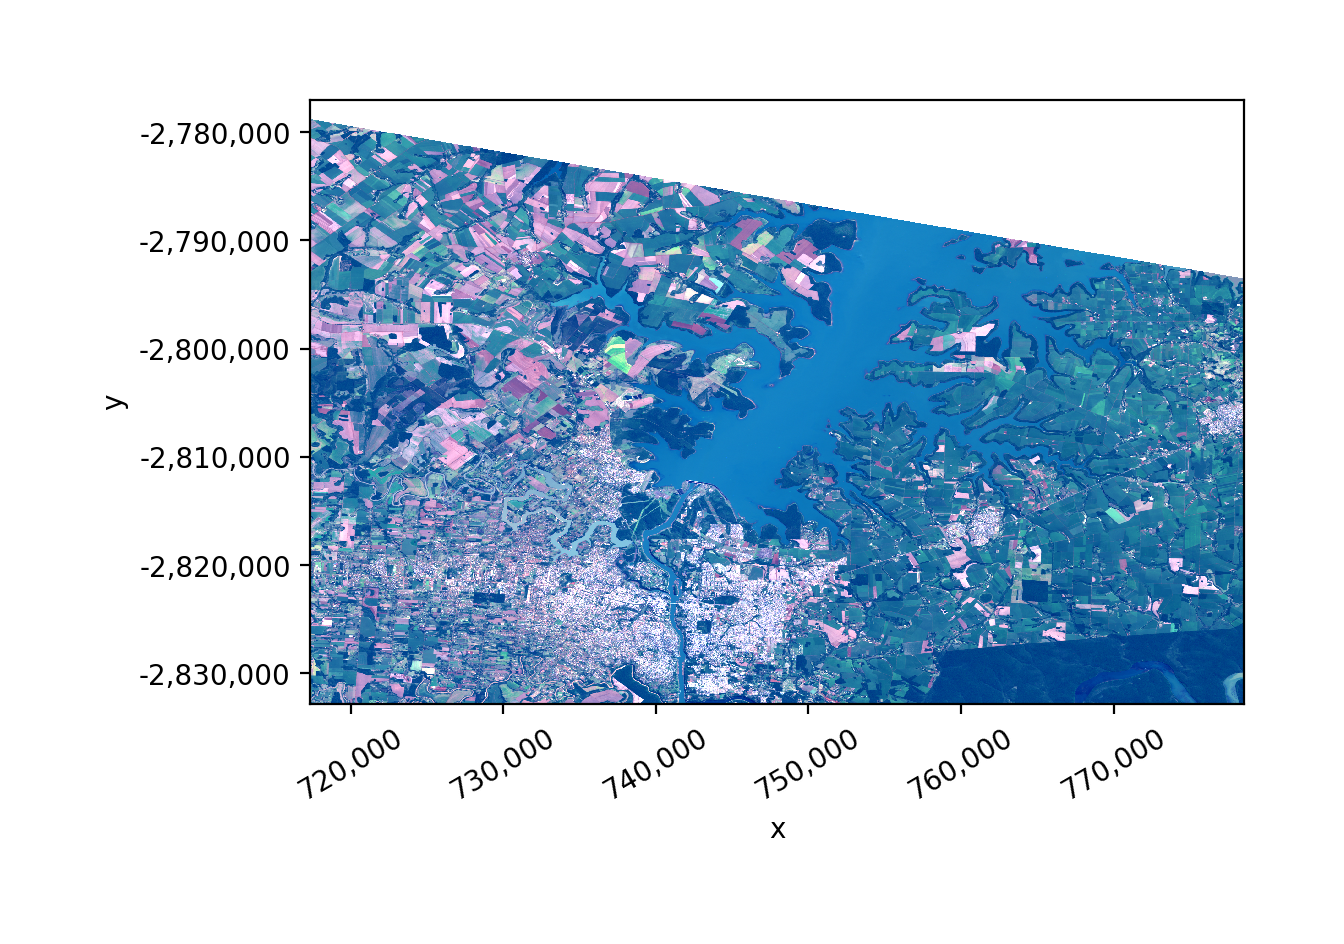

In [2]:
fig, ax = plt.subplots(dpi=200)
with gw.open(l8_224078_20200518) as src:
    src.where(src != 0).sel(band=[3, 2, 1]).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Opening multiple bands as a stack

Often, satellite bands will be stored in separate raster files. To open the files as one DataArray, specify a list instead of a file name.

In [3]:
from geowombat.data import l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4

with gw.open([l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4]) as src:
    print(src)

<xarray.DataArray (time: 3, band: 1, y: 1860, x: 2041)>
dask.array<concatenate, shape=(3, 1, 1860, 2041), dtype=uint16, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * time     (time) int64 1 2 3
Attributes:
    transform:          (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                +init=epsg:32621
    res:                (30.0, 30.0)
    is_tiled:           1
    nodatavals:         (nan,)
    scales:             (1.0,)
    offsets:            (0.0,)
    AREA_OR_POINT:      Point
    filename:           ['LC08_L1TP_224078_20200518_20200518_01_RT_B2.TIF', '...
    resampling:         nearest
    data_are_separate:  1
    data_are_stacked:   1


By default, GeoWombat will stack multiple files by time. So, to stack multiple bands with the same timestamp, change the `stack_dim` keyword.

Also note the use of `band_names` parameter. Here we can set it to anything we want for instance `['blue','green','red']`, but in this case we will keep it simple with `[1,2,3]`

In [4]:
from geowombat.data import l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4

with gw.open(
    [l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4],
    stack_dim="band",
    band_names=[1, 2, 3],
) as src:
    print(src)

<xarray.DataArray (band: 3, y: 1860, x: 2041)>
dask.array<concatenate, shape=(3, 1860, 2041), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
Attributes:
    transform:          (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                +init=epsg:32621
    res:                (30.0, 30.0)
    is_tiled:           1
    nodatavals:         (nan,)
    scales:             (1.0,)
    offsets:            (0.0,)
    AREA_OR_POINT:      Point
    filename:           ['LC08_L1TP_224078_20200518_20200518_01_RT_B2.TIF', '...
    resampling:         nearest
    data_are_separate:  1
    data_are_stacked:   1


You will see this looks the same as the multiband raster:

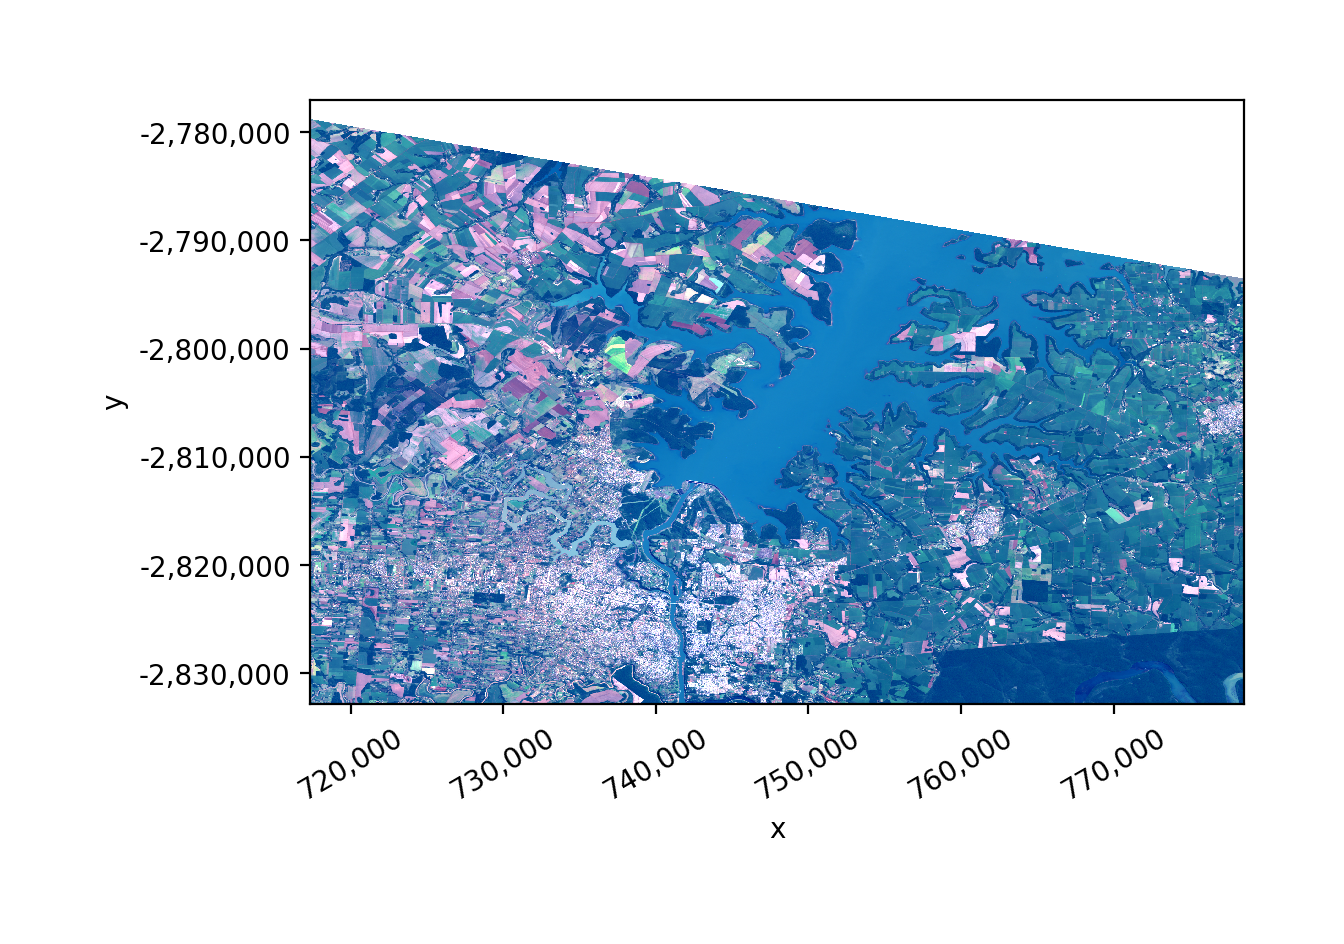

In [5]:
fig, ax = plt.subplots(dpi=200)
with gw.open(
    [l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4],
    stack_dim="band",
    band_names=[1, 2, 3],
) as src:
    src.where(src != 0).sel(band=[3, 2, 1]).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

```{note} 
If time names are not specified with ``stack_dim`` = 'time', GeoWombat will attempt to parse dates from the file names. This could incur significant overhead when the file list is long. Therefore, it is good practice to specify the time names.
```
Overhead required to parse file names

```python
with gw.open(long_file_list, stack_dim='time') as src:
      ...
```

No file parsing overhead

```python
with gw.open(long_file_list, time_names=my_time_names, stack_dim='time') as src:
    ...
```

## Opening multiple bands as a mosaic

When a list of files are given, GeoWombat will stack the data by default. To mosaic multiple files into the same band coordinate, use the **mosaic** keyword.

In [6]:
from geowombat.data import l8_224077_20200518_B2, l8_224078_20200518_B2

with gw.open([l8_224077_20200518_B2, l8_224078_20200518_B2],
              mosaic=True) as src:
    print(src)

<xarray.DataArray (y: 1515, x: 2006, band: 1)>
dask.array<where, shape=(1515, 2006, 1), dtype=uint16, chunksize=(256, 256, 1), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -2.767e+06 -2.767e+06 ... -2.812e+06 -2.812e+06
  * x        (x) float64 6.94e+05 6.940e+05 6.941e+05 ... 7.541e+05 7.542e+05
  * band     (band) int64 1
Attributes:
    transform:          (30.0, 0.0, 694005.0, 0.0, -30.0, -2766615.0)
    crs:                +init=epsg:32621
    res:                (30.0, 30.0)
    is_tiled:           1
    nodatavals:         (nan,)
    scales:             (1.0,)
    offsets:            (0.0,)
    AREA_OR_POINT:      Point
    filename:           ['LC08_L1TP_224077_20200518_20200518_01_RT_B2.TIF', '...
    resampling:         nearest
    data_are_separate:  1
    data_are_stacked:   0


Now let's take a look at the mosaiced band 2 image values.

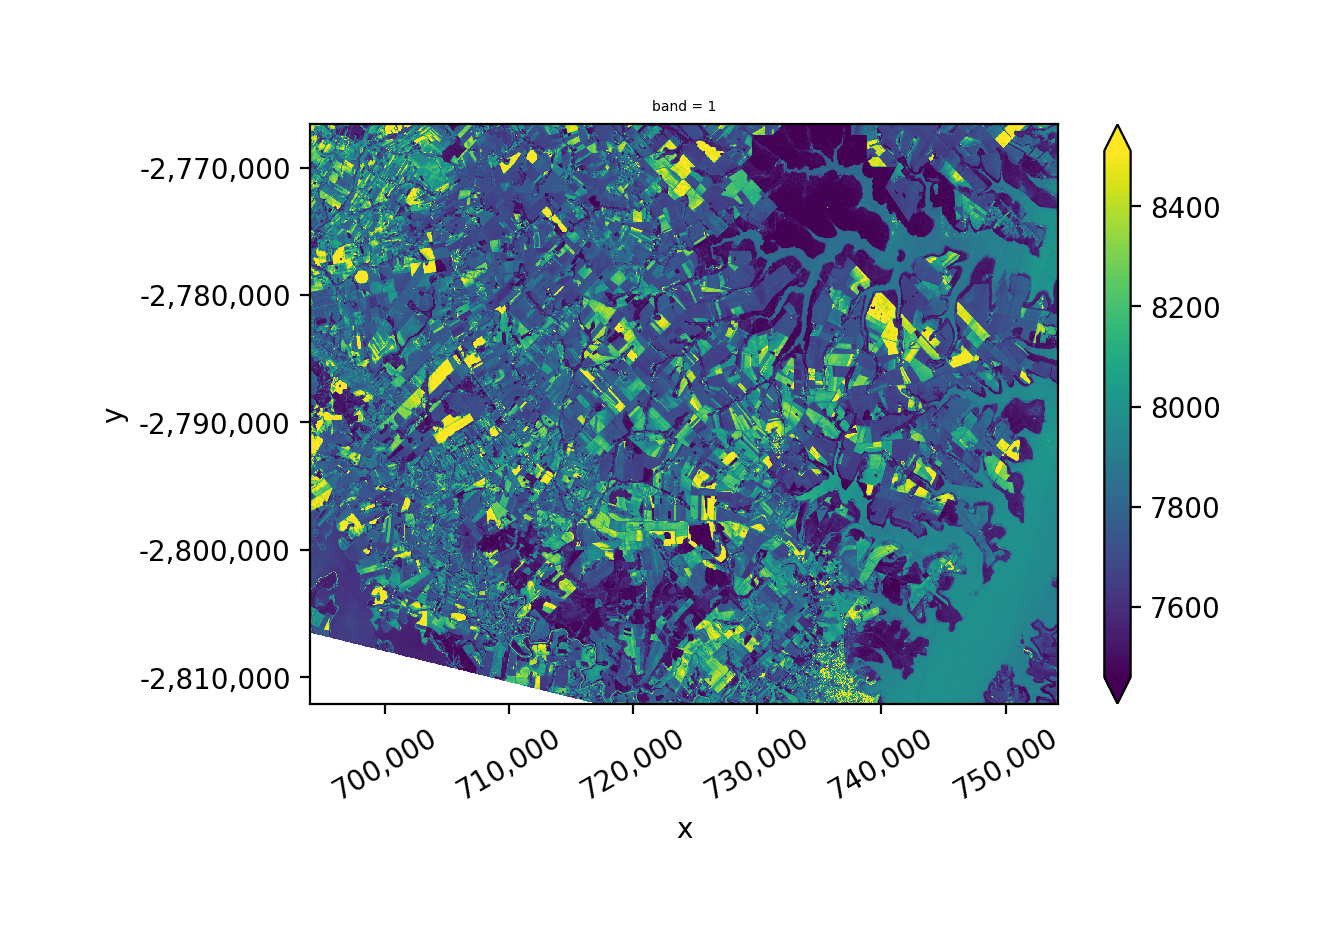

In [7]:
fig, ax = plt.subplots(dpi=200)
with gw.open([l8_224077_20200518_B2, l8_224078_20200518_B2],
              mosaic=True) as src:
    src.where(src != 0).sel(band=1).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

<!-- See :ref:`io` for more examples illustrating file opening. -->